In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Wed Jun 21 19:51:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   30C    P2    55W / 230W |   1480MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [4]:
n_mels = 8
n_outputs = 61
n_frames = 400
sr = 24000
fps = 30
train_csv_files = ['/Storage/speech/face/rvh_viseme2_1_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_2_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_3_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_4_iPhone_raw_30fps.csv',
                  ]
train_wav_files = ['/Storage/speech/face/rvh_viseme2_1_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_2_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_3_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_4_iPhone.wav',
                  ]

test_csv_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone_30fps.csv']
test_wav_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone.wav']

### Model

In [5]:
from model.model_flow3 import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, out_dim=n_outputs)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [6]:
save_dir = '/data/scpark/save/lips/train06.21-3/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 13000, model, None, optimizer)

total 0


In [7]:
import torch
from data.dataset import LipsDataset, Collate

train_dataset = LipsDataset(train_wav_files, train_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=True)
print('train dataset :', len(train_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=1, shuffle=True, batch_size=8, 
                                           collate_fn=Collate(n_frames, n_mels))
print(train_loader)

test_dataset = LipsDataset(test_wav_files, test_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=False)
print('test dataset :', len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, num_workers=1, shuffle=True, batch_size=8,
                                           collate_fn=Collate(n_frames, n_mels))
print(test_loader)

train dataset : 28308
test dataset : 1413


test : 0 0.9212496876716614
test : 1 0.9212450385093689
test : 2 0.9212610721588135
test : 3 0.9212043285369873
test : 4 0.9212150573730469
test : 5 0.9211852550506592
test : 6 0.9211937785148621
test : 7 0.9212812185287476
test : 8 0.9211916327476501
test : 9 0.9213151931762695
test_loss : 0.9212342500686646


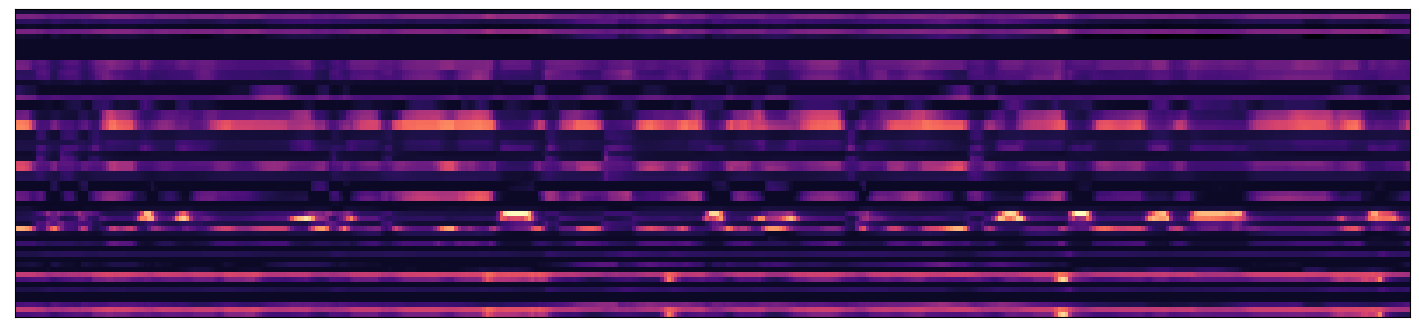

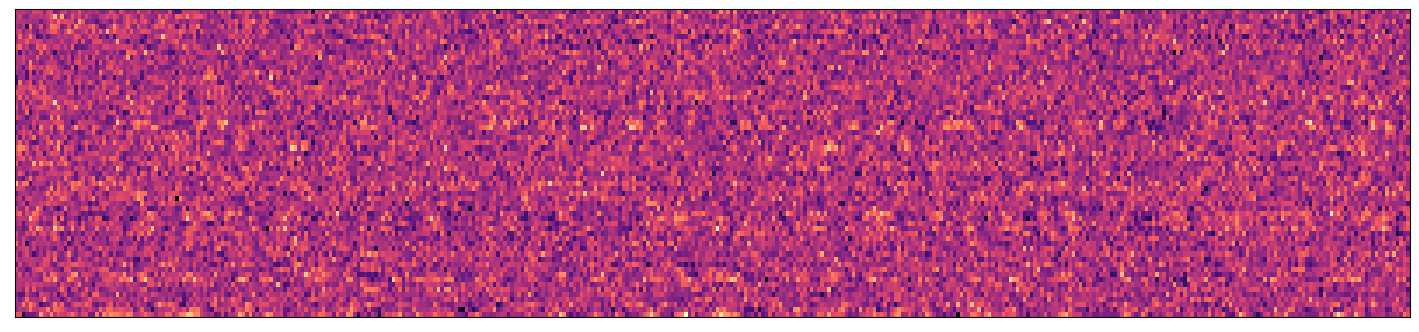

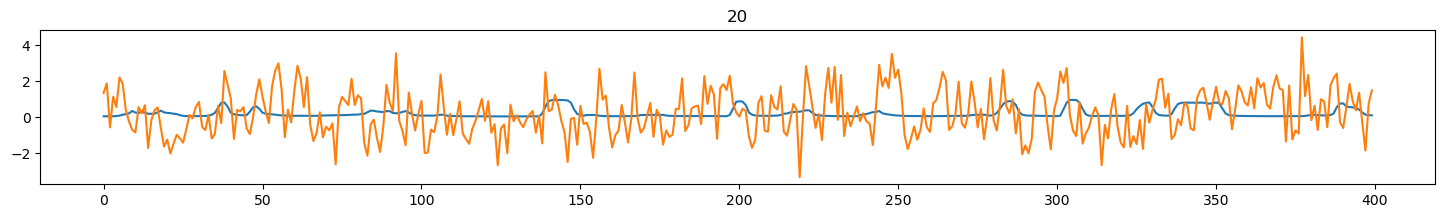

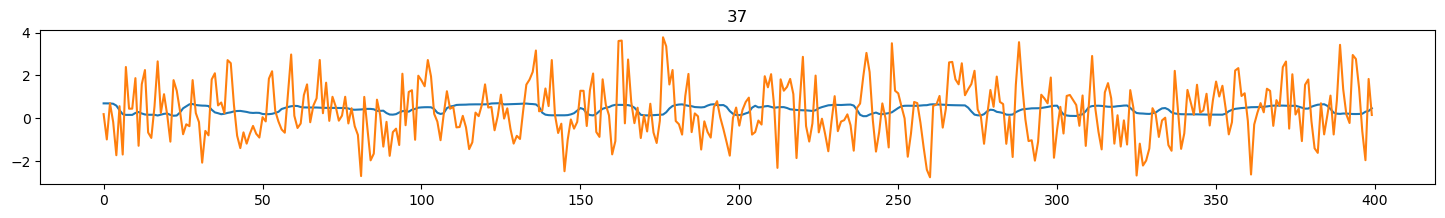

saved /data/scpark/save/lips/train06.21-3/save_5000
5001
5001 0.91901695728302
5002
5002 0.9190328121185303
5003
5003 0.9190258979797363
5004
5004 0.919026255607605
5005
5005 0.9190326929092407
5006
5006 0.9190320372581482
5007
5007 0.9190168976783752
5008
5008 0.9190219640731812
5009
5009 0.9190269708633423
5010
5010 0.919025182723999
5011
5011 0.9190198183059692
5012
5012 0.9190302491188049
5013
5013 0.919017493724823
5014
5014 0.9190062284469604
5015
5015 0.9190078973770142
5016
5016 0.9190220236778259
5017
5017 0.9190129637718201
5018
5018 0.9190277457237244
5019
5019 0.9190342426300049
5020
5020 0.9190278053283691
5021
5021 0.9190348386764526
5022
5022 0.9190143346786499
5023
5023 0.9190163612365723
5024
5024 0.9190360307693481
5025
5025 0.9190278053283691
5026
5026 0.9190232753753662
5027
5027 0.919020414352417
5028
5028 0.9190423488616943
5029
5029 0.9190071821212769
5030
5030 0.9190221428871155
5031
5031 0.9190300703048706
5032
5032 0.9190107583999634
5033
5033 0.91902768611907

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = batch['inputs'].transpose(1, 2).to(device)
        targets = batch['outputs'].transpose(1, 2).to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets)
        
        print(step)
        loss = outputs['total_loss']
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 100 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 100 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = batch['inputs'].transpose(1, 2).to(device)
                targets = batch['outputs'].transpose(1, 2).to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets)
                    
                loss = outputs['total_loss']
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            with torch.no_grad():
                pred = model.inference(inputs)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 1000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)